# 代表的な次元削除を行なう 10本 Knock

## Knock21: PCA を実施してみよう
### 主成分分析（PCA: Principal Component Analysis）
多次元 Data のもつ情報をできるだけ損なわずに低次元にする方法。
- 次元削除で最も簡単な手法でありながら、広い分野で使われている。
- Data を**相関関係にある複数の説明変数**を相関関係の少ない説明変数にまとめる。それにより、相関による Bias が軽減され、Model がより適切な学習が行なえるようになる。
 ※具体的には**分散共分散行列の固有 Vector を取る** 。Data がよくばらついている方向に合わせて空間の軸を取り直す、ということになる。
 >分散共分散行列
 > 変数同士のばらつきをまとめた表

In [3]:
# Iris data の読み込み
from IPython.display import display
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df.loc[df['target'] == 0, 'target_name'] = 'setosa'
df.loc[df['target'] == 1, 'target_name'] = 'versicolor'
df.loc[df['target'] == 2, 'target_name'] = 'virginica'
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


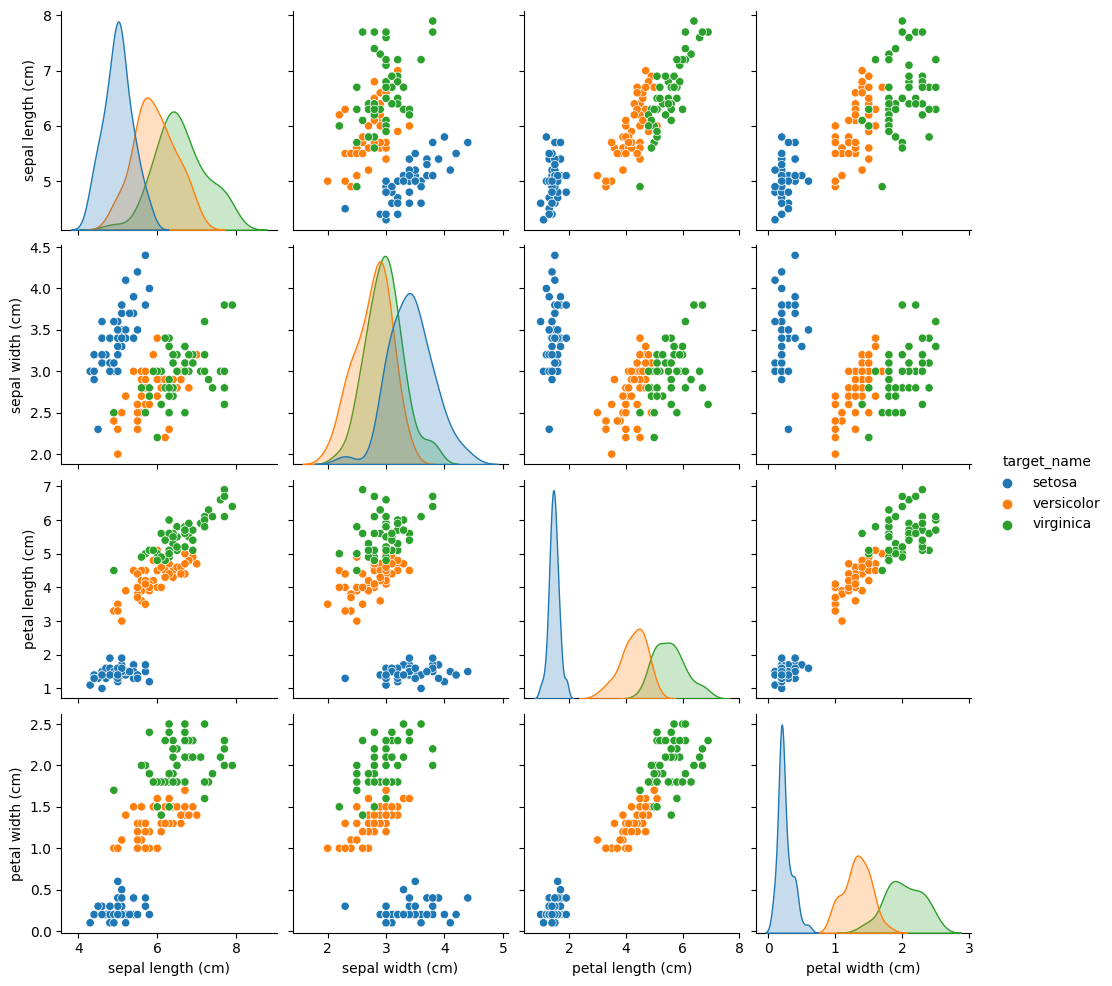

In [4]:
# Iris の散布図行列
import seaborn as sns
sns.pairplot(df, vars=df.columns[:4], hue='target_name')

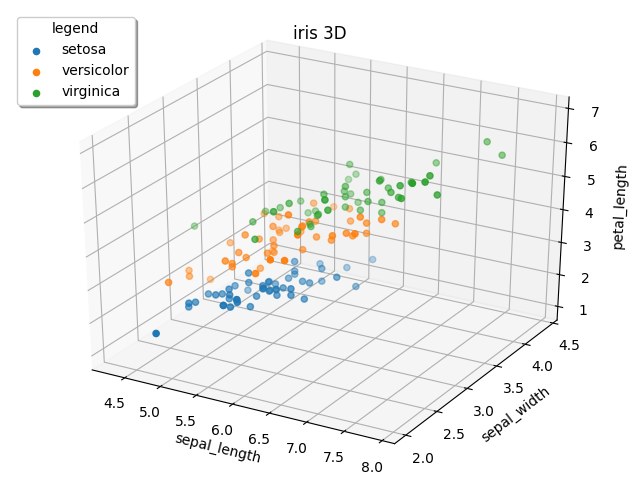

In [5]:
# Iris の３次元立体図
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
for c in df['target_name'].unique():
    ax.scatter(df.iloc[:, 0][df['target_name'] == c], df.iloc[:, 1][df['target_name'] == c],
               df.iloc[:, 2][df['target_name'] == c], label=c)
ax.set_title('iris 3D')
ax.set_xlabel('sepal_length')
ax.set_ylabel('sepal_width')
ax.set_zlabel('petal_length')
ax.legend(loc=2, title='legend', shadow=True)
plt.show()

In [6]:
# PCA 結果
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(random_state=0)
X_pc = pca.fit_transform(df.iloc[:, 0:4])
df_pca = pd.DataFrame(X_pc, columns=['PC{}'.format(i + 1) for i in range(len(X_pc[0]))])
print("主成分の数: ", pca.n_components_)
print("保たれている情報: ", np.sum(pca.explained_variance_ratio_))
display(df_pca.head())

主成分の数:  4
保たれている情報:  1.0


,PC1,PC2,PC3,PC4
0,-2.684126,0.319397,-0.027915,-0.002262
1,-2.714142,-0.177001,-0.210464,-0.099027
2,-2.888991,-0.144949,0.017900,-0.019968
3,-2.745343,-0.318299,0.031559,0.075576
4,-2.728717,0.326755,0.090079,0.061259


#### 主成分（PC: Principal Component
Data を要約（圧縮）したあとの新しい合成変数で、第１主成分（PC1）に最も多くの情報が詰まっていて第２主成分（PC2)以降段々に小さくなる。

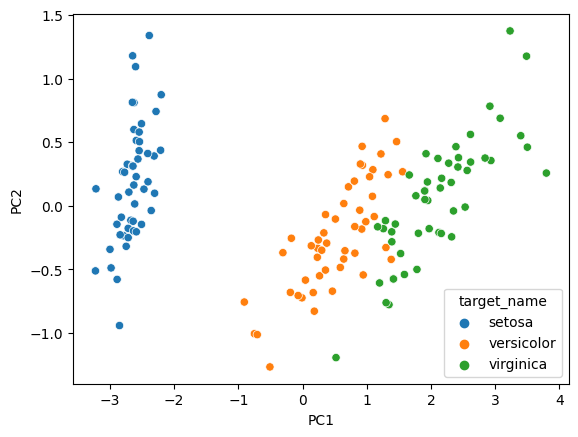

In [7]:
# PC1 と PC2 を可視化
sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue=df['target_name'])

PCA は、多次元 Data の特徴を可視化する手段として、とても有用である。